In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-30 12:13:14--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  12.2MB/s    in 28s     

2022-05-30 12:13:43 (11.3 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1,10000),cutout_ratio=[(0,1)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-30 12:13:44,958 - mmseg - INFO - Loaded 537 images
2022-05-30 12:13:50,199 - mmseg - INFO - Loaded 113 images
2022-05-30 12:13:50,203 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-30 12:13:50,746 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-30 12:13:50,755 - mmseg - INFO - Start running, host: root@ec6526aa0809, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1
2022-05-30 12:13:50,757 - mmseg - INFO - Hooks will be executed i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 836s, ETA:     0s

2022-05-30 12:37:26,836 - mmseg - INFO - per class results:
2022-05-30 12:37:26,839 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  85.9 | 89.82 |
|  building  | 72.01 | 86.83 |
|  Boundary  | 44.93 | 65.68 |
+------------+-------+-------+
2022-05-30 12:37:26,840 - mmseg - INFO - Summary:
2022-05-30 12:37:26,842 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.72 | 67.61 | 80.78 |
+-------+-------+-------+
2022-05-30 12:37:26,844 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8572, mIoU: 0.6761, mAcc: 0.8078, IoU.background: 0.8590, IoU.building: 0.7201, IoU.Boundary: 0.4493, Acc.background: 0.8982, Acc.building: 0.8683, Acc.Boundary: 0.6568
2022-05-30 12:38:11,326 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 6:58:14, time: 8.803, data_time: 8.388, memory: 3323, decode.loss_dice: 0.2010, decode.loss_focal: 0.0448, decode.loss_lovasz: 0.3775, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 760s, ETA:     0s

2022-05-30 12:57:12,755 - mmseg - INFO - per class results:
2022-05-30 12:57:12,757 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.39 | 91.99 |
|  building  | 73.71 | 86.66 |
|  Boundary  | 48.22 | 66.62 |
+------------+-------+-------+
2022-05-30 12:57:12,759 - mmseg - INFO - Summary:
2022-05-30 12:57:12,761 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.15 | 69.78 | 81.76 |
+-------+-------+-------+
2022-05-30 12:57:12,764 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8715, mIoU: 0.6978, mAcc: 0.8176, IoU.background: 0.8739, IoU.building: 0.7371, IoU.Boundary: 0.4822, Acc.background: 0.9199, Acc.building: 0.8666, Acc.Boundary: 0.6662
2022-05-30 12:57:53,933 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 6:15:29, time: 8.007, data_time: 7.601, memory: 3323, decode.loss_dice: 0.1788, decode.loss_focal: 0.0439, decode.loss_lovasz: 0.3458, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 13:17:02,141 - mmseg - INFO - per class results:
2022-05-30 13:17:02,142 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.88 | 92.91 |
|  building  | 76.61 | 89.35 |
|  Boundary  | 49.49 | 66.53 |
+------------+-------+-------+
2022-05-30 13:17:02,144 - mmseg - INFO - Summary:
2022-05-30 13:17:02,147 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.35 | 71.66 | 82.93 |
+-------+-------+-------+
2022-05-30 13:17:02,149 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8835, mIoU: 0.7166, mAcc: 0.8293, IoU.background: 0.8888, IoU.building: 0.7661, IoU.Boundary: 0.4949, Acc.background: 0.9291, Acc.building: 0.8935, Acc.Boundary: 0.6653
2022-05-30 13:17:43,825 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 5:48:15, time: 8.022, data_time: 7.611, memory: 3323, decode.loss_dice: 0.1681, decode.loss_focal: 0.0408, decode.loss_lovasz: 0.3346, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 760s, ETA:     0s

2022-05-30 13:36:46,538 - mmseg - INFO - per class results:
2022-05-30 13:36:46,540 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.68 | 92.59 |
|  building  | 76.53 | 89.47 |
|  Boundary  |  49.4 | 66.86 |
+------------+-------+-------+
2022-05-30 13:36:46,542 - mmseg - INFO - Summary:
2022-05-30 13:36:46,543 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.23 | 71.54 | 82.97 |
+-------+-------+-------+
2022-05-30 13:36:46,546 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8823, mIoU: 0.7154, mAcc: 0.8297, IoU.background: 0.8868, IoU.building: 0.7653, IoU.Boundary: 0.4940, Acc.background: 0.9259, Acc.building: 0.8947, Acc.Boundary: 0.6686
2022-05-30 13:37:28,358 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 5:24:18, time: 8.017, data_time: 7.604, memory: 3328, decode.loss_dice: 0.1510, decode.loss_focal: 0.0386, decode.loss_lovasz: 0.3054, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 13:56:29,657 - mmseg - INFO - per class results:
2022-05-30 13:56:29,659 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.46 | 94.27 |
|  building  | 77.26 | 86.68 |
|  Boundary  | 51.34 | 69.02 |
+------------+-------+-------+
2022-05-30 13:56:29,660 - mmseg - INFO - Summary:
2022-05-30 13:56:29,664 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 88.9 | 72.68 | 83.32 |
+------+-------+-------+
2022-05-30 13:56:29,666 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8890, mIoU: 0.7268, mAcc: 0.8332, IoU.background: 0.8946, IoU.building: 0.7726, IoU.Boundary: 0.5134, Acc.background: 0.9427, Acc.building: 0.8668, Acc.Boundary: 0.6902
2022-05-30 13:57:11,750 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 5:01:56, time: 8.032, data_time: 7.618, memory: 3328, decode.loss_dice: 0.1536, decode.loss_focal: 0.0381, decode.loss_lovasz: 0.3105, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 760s, ETA:     0s

2022-05-30 14:16:20,210 - mmseg - INFO - per class results:
2022-05-30 14:16:20,212 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.76 | 95.08 |
|  building  |  76.8 | 85.44 |
|  Boundary  | 51.53 | 68.46 |
+------------+-------+-------+
2022-05-30 14:16:20,214 - mmseg - INFO - Summary:
2022-05-30 14:16:20,215 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.01 | 72.7 | 82.99 |
+-------+------+-------+
2022-05-30 14:16:20,218 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8901, mIoU: 0.7270, mAcc: 0.8299, IoU.background: 0.8976, IoU.building: 0.7680, IoU.Boundary: 0.5153, Acc.background: 0.9508, Acc.building: 0.8544, Acc.Boundary: 0.6846
2022-05-30 14:17:02,069 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 4:40:42, time: 8.023, data_time: 7.611, memory: 3328, decode.loss_dice: 0.1590, decode.loss_focal: 0.0393, decode.loss_lovasz: 0.3080, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 760s, ETA:     0s

2022-05-30 14:36:09,000 - mmseg - INFO - per class results:
2022-05-30 14:36:09,002 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.22 |  93.7 |
|  building  | 77.52 | 87.31 |
|  Boundary  | 51.38 | 69.82 |
+------------+-------+-------+
2022-05-30 14:36:09,005 - mmseg - INFO - Summary:
2022-05-30 14:36:09,008 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.81 | 72.71 | 83.61 |
+-------+-------+-------+
2022-05-30 14:36:09,011 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8881, mIoU: 0.7271, mAcc: 0.8361, IoU.background: 0.8922, IoU.building: 0.7752, IoU.Boundary: 0.5138, Acc.background: 0.9370, Acc.building: 0.8731, Acc.Boundary: 0.6982
2022-05-30 14:36:50,383 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 4:19:48, time: 8.019, data_time: 7.611, memory: 3328, decode.loss_dice: 0.1491, decode.loss_focal: 0.0355, decode.loss_lovasz: 0.3026, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 14:55:51,039 - mmseg - INFO - per class results:
2022-05-30 14:55:51,041 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  89.7 | 93.52 |
|  building  | 77.79 | 87.73 |
|  Boundary  | 52.94 | 72.33 |
+------------+-------+-------+
2022-05-30 14:55:51,043 - mmseg - INFO - Summary:
2022-05-30 14:55:51,046 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.15 | 73.48 | 84.53 |
+-------+-------+-------+
2022-05-30 14:55:51,048 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8915, mIoU: 0.7348, mAcc: 0.8453, IoU.background: 0.8970, IoU.building: 0.7779, IoU.Boundary: 0.5294, Acc.background: 0.9352, Acc.building: 0.8773, Acc.Boundary: 0.7233
2022-05-30 14:56:34,856 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 3:59:04, time: 8.046, data_time: 7.637, memory: 3328, decode.loss_dice: 0.1424, decode.loss_focal: 0.0339, decode.loss_lovasz: 0.2913, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 15:15:36,330 - mmseg - INFO - per class results:
2022-05-30 15:15:36,332 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.98 | 93.95 |
|  building  | 77.86 | 88.73 |
|  Boundary  | 52.51 | 69.74 |
+------------+-------+-------+
2022-05-30 15:15:36,333 - mmseg - INFO - Summary:
2022-05-30 15:15:36,337 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.3 | 73.45 | 84.14 |
+------+-------+-------+
2022-05-30 15:15:36,340 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8930, mIoU: 0.7345, mAcc: 0.8414, IoU.background: 0.8998, IoU.building: 0.7786, IoU.Boundary: 0.5251, Acc.background: 0.9395, Acc.building: 0.8873, Acc.Boundary: 0.6974
2022-05-30 15:16:17,220 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 3:38:31, time: 8.023, data_time: 7.620, memory: 3328, decode.loss_dice: 0.1420, decode.loss_focal: 0.0382, decode.loss_lovasz: 0.2891, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 763s, ETA:     0s

2022-05-30 15:35:17,822 - mmseg - INFO - per class results:
2022-05-30 15:35:17,823 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.73 | 93.45 |
|  building  | 77.67 | 88.94 |
|  Boundary  | 52.68 | 70.61 |
+------------+-------+-------+
2022-05-30 15:35:17,828 - mmseg - INFO - Summary:
2022-05-30 15:35:17,831 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.16 | 73.36 | 84.33 |
+-------+-------+-------+
2022-05-30 15:35:17,833 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8916, mIoU: 0.7336, mAcc: 0.8433, IoU.background: 0.8973, IoU.building: 0.7767, IoU.Boundary: 0.5268, Acc.background: 0.9345, Acc.building: 0.8894, Acc.Boundary: 0.7061
2022-05-30 15:35:58,510 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 3:18:07, time: 8.039, data_time: 7.638, memory: 3328, decode.loss_dice: 0.1365, decode.loss_focal: 0.0338, decode.loss_lovasz: 0.2845, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 760s, ETA:     0s

2022-05-30 15:54:57,435 - mmseg - INFO - per class results:
2022-05-30 15:54:57,436 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.41 | 95.53 |
|  building  | 78.52 | 88.32 |
|  Boundary  | 51.95 |  66.1 |
+------------+-------+-------+
2022-05-30 15:54:57,438 - mmseg - INFO - Summary:
2022-05-30 15:54:57,439 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.66 | 73.63 | 83.32 |
+-------+-------+-------+
2022-05-30 15:54:57,442 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8966, mIoU: 0.7363, mAcc: 0.8332, IoU.background: 0.9041, IoU.building: 0.7852, IoU.Boundary: 0.5195, Acc.background: 0.9553, Acc.building: 0.8832, Acc.Boundary: 0.6610
2022-05-30 15:55:38,684 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:57:50, time: 8.010, data_time: 7.603, memory: 3328, decode.loss_dice: 0.1444, decode.loss_focal: 0.0366, decode.loss_lovasz: 0.2945, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 16:14:40,933 - mmseg - INFO - per class results:
2022-05-30 16:14:40,936 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.46 | 95.23 |
|  building  | 78.07 | 86.79 |
|  Boundary  | 52.63 | 69.43 |
+------------+-------+-------+
2022-05-30 16:14:40,937 - mmseg - INFO - Summary:
2022-05-30 16:14:40,940 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.57 | 73.72 | 83.82 |
+-------+-------+-------+
2022-05-30 16:14:40,944 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8957, mIoU: 0.7372, mAcc: 0.8382, IoU.background: 0.9046, IoU.building: 0.7807, IoU.Boundary: 0.5263, Acc.background: 0.9523, Acc.building: 0.8679, Acc.Boundary: 0.6943
2022-05-30 16:15:21,829 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 2:37:41, time: 8.019, data_time: 7.616, memory: 3328, decode.loss_dice: 0.1290, decode.loss_focal: 0.0313, decode.loss_lovasz: 0.2727, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 16:34:24,386 - mmseg - INFO - per class results:
2022-05-30 16:34:24,388 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.28 | 94.06 |
|  building  | 78.85 | 88.39 |
|  Boundary  | 53.16 |  71.8 |
+------------+-------+-------+
2022-05-30 16:34:24,390 - mmseg - INFO - Summary:
2022-05-30 16:34:24,392 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.57 | 74.09 | 84.75 |
+-------+-------+-------+
2022-05-30 16:34:24,398 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8957, mIoU: 0.7409, mAcc: 0.8475, IoU.background: 0.9028, IoU.building: 0.7885, IoU.Boundary: 0.5316, Acc.background: 0.9406, Acc.building: 0.8839, Acc.Boundary: 0.7180
2022-05-30 16:35:05,579 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 2:17:36, time: 8.023, data_time: 7.617, memory: 3328, decode.loss_dice: 0.1259, decode.loss_focal: 0.0310, decode.loss_lovasz: 0.2661, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 760s, ETA:     0s

2022-05-30 16:54:05,933 - mmseg - INFO - per class results:
2022-05-30 16:54:05,935 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.44 | 94.38 |
|  building  | 78.92 | 89.93 |
|  Boundary  | 52.81 | 68.74 |
+------------+-------+-------+
2022-05-30 16:54:05,936 - mmseg - INFO - Summary:
2022-05-30 16:54:05,938 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.71 | 74.06 | 84.35 |
+-------+-------+-------+
2022-05-30 16:54:05,942 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8971, mIoU: 0.7406, mAcc: 0.8435, IoU.background: 0.9044, IoU.building: 0.7892, IoU.Boundary: 0.5281, Acc.background: 0.9438, Acc.building: 0.8993, Acc.Boundary: 0.6874
2022-05-30 16:54:47,584 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:57:33, time: 8.020, data_time: 7.609, memory: 3328, decode.loss_dice: 0.1374, decode.loss_focal: 0.0342, decode.loss_lovasz: 0.2842, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 762s, ETA:     0s

2022-05-30 17:13:47,968 - mmseg - INFO - per class results:
2022-05-30 17:13:47,971 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.28 |  93.9 |
|  building  | 78.92 | 88.24 |
|  Boundary  | 53.85 |  73.2 |
+------------+-------+-------+
2022-05-30 17:13:47,973 - mmseg - INFO - Summary:
2022-05-30 17:13:47,977 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.63 | 74.35 | 85.12 |
+-------+-------+-------+
2022-05-30 17:13:47,979 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8963, mIoU: 0.7435, mAcc: 0.8512, IoU.background: 0.9028, IoU.building: 0.7892, IoU.Boundary: 0.5385, Acc.background: 0.9390, Acc.building: 0.8824, Acc.Boundary: 0.7320
2022-05-30 17:14:30,923 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:37:34, time: 8.049, data_time: 7.646, memory: 3328, decode.loss_dice: 0.1283, decode.loss_focal: 0.0321, decode.loss_lovasz: 0.2743, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 763s, ETA:     0s

2022-05-30 17:33:34,690 - mmseg - INFO - per class results:
2022-05-30 17:33:34,692 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.75 |  94.8 |
|  building  | 79.36 | 88.36 |
|  Boundary  | 54.15 | 71.56 |
+------------+-------+-------+
2022-05-30 17:33:34,694 - mmseg - INFO - Summary:
2022-05-30 17:33:34,696 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.99 | 74.75 | 84.91 |
+-------+-------+-------+
2022-05-30 17:33:34,699 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8999, mIoU: 0.7475, mAcc: 0.8491, IoU.background: 0.9075, IoU.building: 0.7936, IoU.Boundary: 0.5415, Acc.background: 0.9480, Acc.building: 0.8836, Acc.Boundary: 0.7156
2022-05-30 17:34:15,867 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 1:17:36, time: 8.045, data_time: 7.639, memory: 3328, decode.loss_dice: 0.1240, decode.loss_focal: 0.0312, decode.loss_lovasz: 0.2632, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 762s, ETA:     0s

2022-05-30 17:53:17,765 - mmseg - INFO - per class results:
2022-05-30 17:53:17,767 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.34 | 93.56 |
|  building  | 78.91 | 87.28 |
|  Boundary  | 54.37 | 76.23 |
+------------+-------+-------+
2022-05-30 17:53:17,770 - mmseg - INFO - Summary:
2022-05-30 17:53:17,772 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.61 | 74.54 | 85.69 |
+-------+-------+-------+
2022-05-30 17:53:17,775 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8961, mIoU: 0.7454, mAcc: 0.8569, IoU.background: 0.9034, IoU.building: 0.7891, IoU.Boundary: 0.5437, Acc.background: 0.9356, Acc.building: 0.8728, Acc.Boundary: 0.7623
2022-05-30 17:53:58,644 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:57:40, time: 8.027, data_time: 7.624, memory: 3328, decode.loss_dice: 0.1217, decode.loss_focal: 0.0281, decode.loss_lovasz: 0.2581, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 762s, ETA:     0s

2022-05-30 18:13:00,655 - mmseg - INFO - per class results:
2022-05-30 18:13:00,657 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.78 | 94.82 |
|  building  | 79.21 | 87.42 |
|  Boundary  |  54.5 | 73.05 |
+------------+-------+-------+
2022-05-30 18:13:00,658 - mmseg - INFO - Summary:
2022-05-30 18:13:00,660 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.98 | 74.83 | 85.1 |
+-------+-------+------+
2022-05-30 18:13:00,662 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8998, mIoU: 0.7483, mAcc: 0.8510, IoU.background: 0.9078, IoU.building: 0.7921, IoU.Boundary: 0.5450, Acc.background: 0.9482, Acc.building: 0.8742, Acc.Boundary: 0.7305
2022-05-30 18:13:42,177 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:37:46, time: 8.035, data_time: 7.625, memory: 3328, decode.loss_dice: 0.1243, decode.loss_focal: 0.0311, decode.loss_lovasz: 0.2645, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 18:32:42,155 - mmseg - INFO - per class results:
2022-05-30 18:32:42,157 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.91 | 95.44 |
|  building  |  79.0 | 86.87 |
|  Boundary  | 54.29 | 71.63 |
+------------+-------+-------+
2022-05-30 18:32:42,159 - mmseg - INFO - Summary:
2022-05-30 18:32:42,160 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.03 | 74.73 | 84.65 |
+-------+-------+-------+
2022-05-30 18:32:42,162 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9003, mIoU: 0.7473, mAcc: 0.8465, IoU.background: 0.9091, IoU.building: 0.7900, IoU.Boundary: 0.5429, Acc.background: 0.9544, Acc.building: 0.8687, Acc.Boundary: 0.7163
2022-05-30 18:33:23,048 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:17:53, time: 8.020, data_time: 7.617, memory: 3328, decode.loss_dice: 0.1190, decode.loss_focal: 0.0276, decode.loss_lovasz: 0.2538, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 761s, ETA:     0s

2022-05-30 18:52:22,872 - mmseg - INFO - per class results:
2022-05-30 18:52:22,874 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.75 | 94.55 |
|  building  | 79.32 | 88.61 |
|  Boundary  | 54.22 | 72.06 |
+------------+-------+-------+
2022-05-30 18:52:22,877 - mmseg - INFO - Summary:
2022-05-30 18:52:22,878 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.96 | 74.76 | 85.07 |
+-------+-------+-------+
2022-05-30 18:52:22,880 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8996, mIoU: 0.7476, mAcc: 0.8507, IoU.background: 0.9075, IoU.building: 0.7932, IoU.Boundary: 0.5422, Acc.background: 0.9455, Acc.building: 0.8861, Acc.Boundary: 0.7206


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


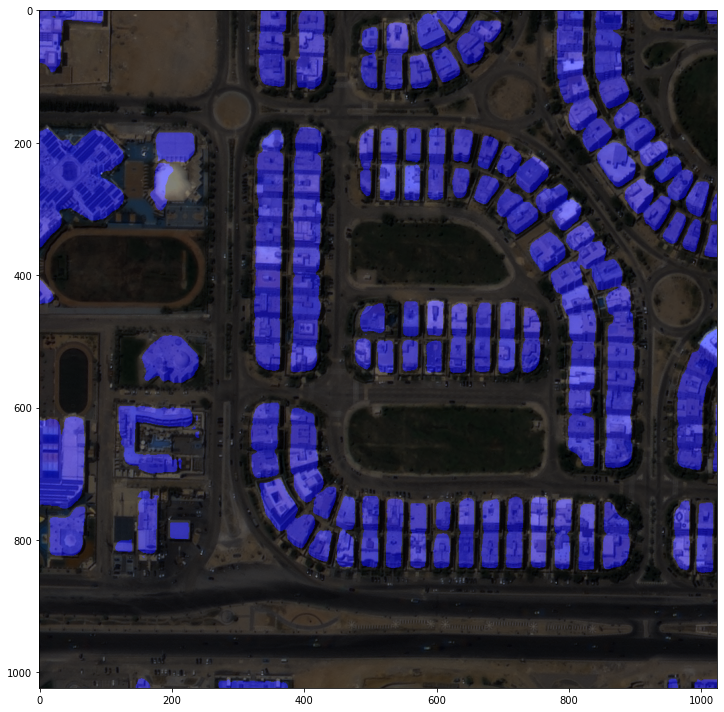

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


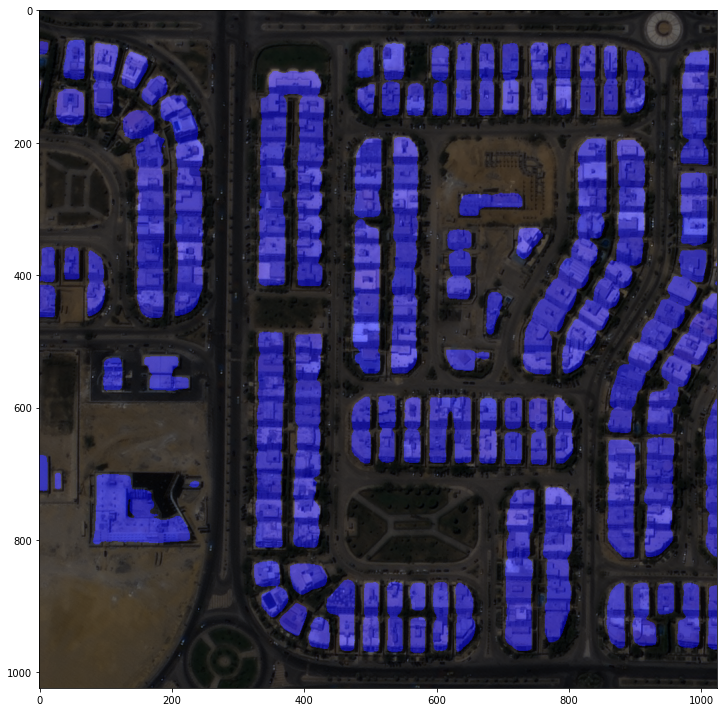

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


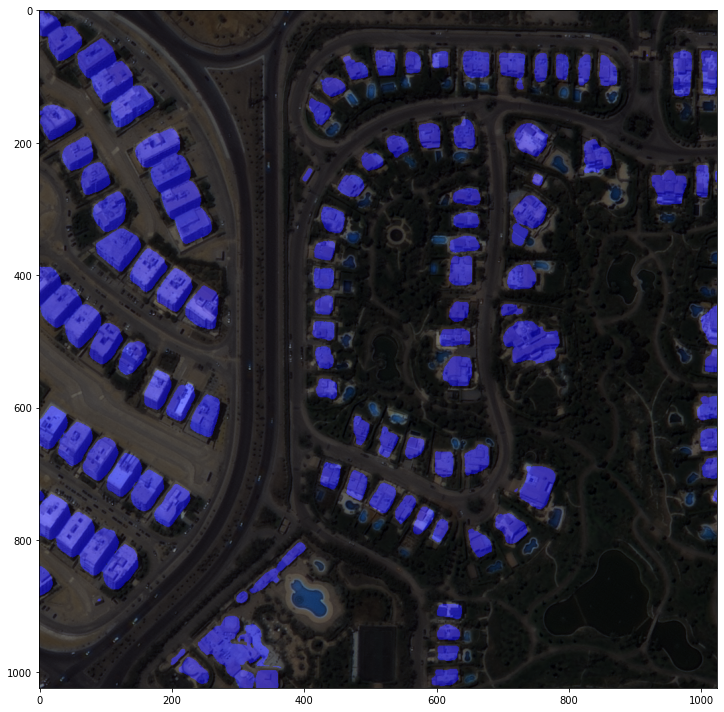

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


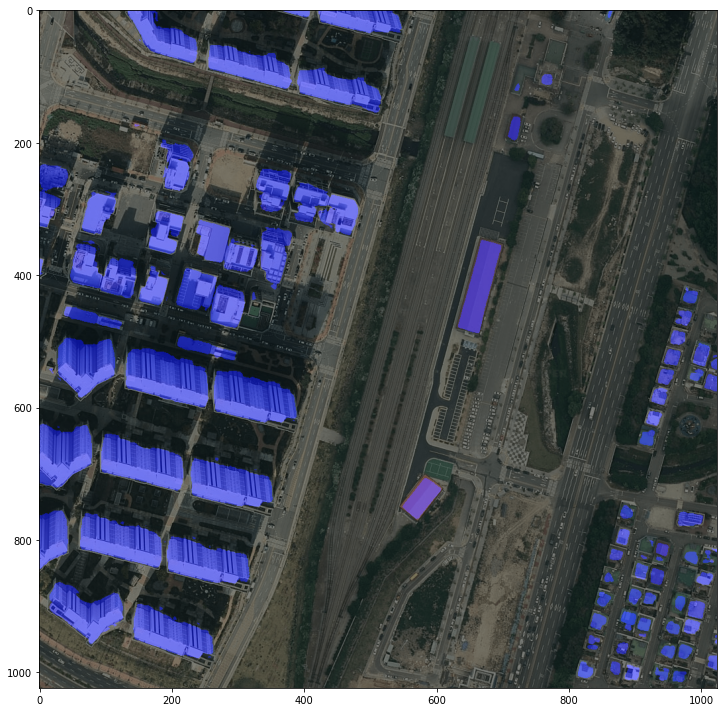

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)